In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn

from torchmeta.datasets.helpers import omniglot
from torchmeta.datasets import Omniglot
from torchmeta.utils.data import BatchMetaDataLoader
import matplotlib.pyplot as plt

from dotted.utils import dot
import hypernet as hn
from tqdm import tqdm
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
N, K = 5, 5

dataset = omniglot("data", ways=N, shots=K, test_shots=15, meta_train=True, download=True)
dataloader = BatchMetaDataLoader(
    dataset, batch_size=128, num_workers=0, 
#     shuffle=True
    shuffle=True
)

In [5]:
for T in dataloader:
    break

/home/mprzewie/.anaconda3/envs/uj/lib/python3.8/site-packages/torchvision/transforms/functional.py:942: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [6]:
def plot_task(
    x_train, y_train, x_test, y_test, n
):
    for (t, x,y) in [("train",x_train, y_train), ("test", x_test, y_test)]:
        k = len(x) // n
        fig, ax = plt.subplots(n, k, figsize=(1.5*k, 1.5*n))
        for n_ in range(n):
            for k_ in range(k):
                i = n_*k + k_
                ax[n_,k_].imshow(x[i].squeeze())
                ax[n_,k_].set_title(f"{y[i]}")
                ax[n_,k_].axis("off")
        fig.suptitle(t)
        
        
#     print([t.shape for t in [x_train, y_train, x_test, y_test]])

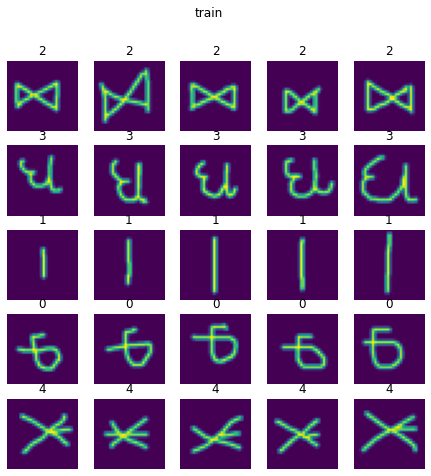

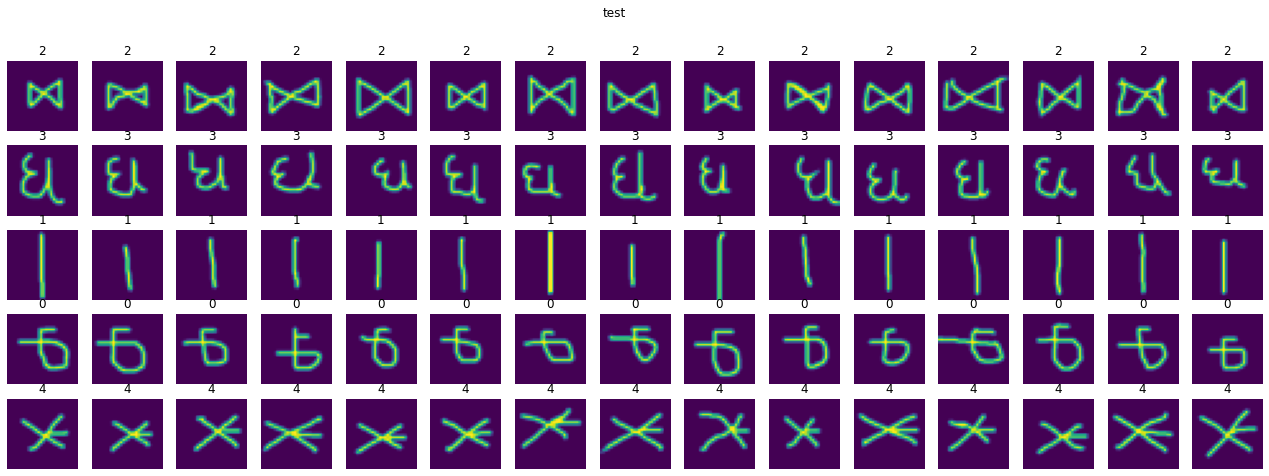

In [7]:
x_train, y_train = T["train"]
x_test, y_test = T["test"]

plot_task(x_train[0], y_train[0], x_test[0], y_test[0], N)

In [8]:
target_net = nn.Sequential(
        nn.Conv2d(1, 8, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(8, 16, 3, padding=1, stride=2),
        nn.ReLU(),
        nn.Conv2d(16, 16, 3, padding=1, stride=2),
        nn.Flatten(),
        nn.Linear(7*7*16, 128),
        nn.ReLU(),
        nn.Linear(128, N)
    )



In [9]:
hypernet = hn.HyperNetwork(
    target_network=target_net,
    n=N, k=K,
    fe_out_size=256
)
hypernet.to(device)

loss_fn = nn.CrossEntropyLoss()
h_opt = torch.optim.Adam(hypernet.parameters(), lr=4e-4)
sum(p.numel() for p in hypernet.parameters())

44312757

In [10]:
Y_train_fixed = torch.tensor(
    [
        c 
        for c in range(N)
        for s in range(K)

    ]
).to(device)
Y_train_fixed

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4], device='cuda:0')

In [11]:
n_tasksets = 100
taskset_epochs = 1

for task_set_id, tasks in enumerate(tqdm(dataloader, total=n_tasksets)):

    for e in range(taskset_epochs):
        X_train, Y_train = tasks["train"]
        X_test, Y_test = tasks["test"]

        X_train, X_test, Y_train, Y_test = [t.to(device) for t in [X_train, X_test, Y_train, Y_test]]


        train_losses = []
        train_accs = []

        test_losses = []
        test_accs = []
        h_opt.zero_grad()
        loss_sum = 0
        

        for t_id, (x_train, y_train, x_test, y_test) in enumerate(zip(X_train, Y_train, X_test, Y_test)):
            y_train = Y_train_fixed

#                 plot_task(x_train, y_train, x_test, y_test, N)
#                 raise RuntimeError("dupa")

        
            tn = hypernet(x_train, y_train)
            
#             x_train = hn.append_onehot_channels(x_train, y_train, N)
            y_pred = tn(x_train)

            loss = loss_fn(y_pred, y_train)
            loss_sum = loss_sum + loss
            train_acc = (y_pred.argmax(dim=1) == y_train).sum() / len(y_train)

            train_losses.append(loss.item())
            train_accs.append(train_acc.item())
            
#             if t_id==0:
#                 plot_task(x_train.to("cpu"), y_train.to("cpu"), x_test.to("cpu"), y_test.to("cpu"), N)
#                 plt.show()


#             print(hypernet.fe[0].weight.grad.max(), hypernet.fe[0].weight.grad.min())

#             x_test, y_test = T["test"]
#             x_test, y_test = [t[t_id].to(device) for t in [x_test, y_test]]
#             y_pred = target_net(x_test)
#             loss = loss_fn(y_pred, y_test)

#             test_acc = (y_pred.argmax(dim=1) == y_test).sum() / len(y_test)

#             test_losses.append(loss.item())
#             test_accs.append(test_acc.item())
        loss_sum.backward()
        h_opt.step()
        print(
            task_set_id, 
            e,
            {
                "tr_l": np.mean(train_losses).item(),
                "te_l": np.mean(test_losses).item(),
                "tr_a": np.mean(train_accs).item(),
                "te_a": np.mean(test_accs).item()
            } 
             )

    if task_set_id == n_tasksets-1:
        break
    


  0%|          | 0/100 [00:00<?, ?it/s]/home/mprzewie/.anaconda3/envs/uj/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mprzewie/.anaconda3/envs/uj/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  1%|          | 1/100 [00:04<06:36,  4.01s/it]

0 0 {'tr_l': 1.6099296705797315, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


  2%|▏         | 2/100 [00:07<06:25,  3.94s/it]

1 0 {'tr_l': 28.587329119443893, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


  3%|▎         | 3/100 [00:11<06:18,  3.91s/it]

2 0 {'tr_l': 1.6185458740219474, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


  4%|▍         | 4/100 [00:15<06:13,  3.89s/it]

3 0 {'tr_l': 1.6096564857289195, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


  5%|▌         | 5/100 [00:19<06:08,  3.88s/it]

4 0 {'tr_l': 1.6108566280454397, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


  6%|▌         | 6/100 [00:23<06:04,  3.88s/it]

5 0 {'tr_l': 1.6101994337514043, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


  7%|▋         | 7/100 [00:27<06:00,  3.88s/it]

6 0 {'tr_l': 1.7629123870283365, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


  8%|▊         | 8/100 [00:31<05:57,  3.89s/it]

7 0 {'tr_l': 1.6167441876605153, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


  9%|▉         | 9/100 [00:35<05:52,  3.87s/it]

8 0 {'tr_l': 1.6123579312115908, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 10%|█         | 10/100 [00:38<05:49,  3.88s/it]

9 0 {'tr_l': 1.61157217156142, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 11%|█         | 11/100 [00:42<05:45,  3.89s/it]

10 0 {'tr_l': 1.64759789314121, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 12%|█▏        | 12/100 [00:46<05:41,  3.88s/it]

11 0 {'tr_l': 1.830708091147244, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 13%|█▎        | 13/100 [00:50<05:40,  3.92s/it]

12 0 {'tr_l': 1.6100207101553679, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 14%|█▍        | 14/100 [00:54<05:38,  3.94s/it]

13 0 {'tr_l': 1.6323133828118443, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 15%|█▌        | 15/100 [00:58<05:39,  3.99s/it]

14 0 {'tr_l': 1.6624160362407565, 'te_l': nan, 'tr_a': 0.20781249325955287, 'te_a': nan}


 16%|█▌        | 16/100 [01:02<05:35,  3.99s/it]

15 0 {'tr_l': 1.6465780436992645, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 17%|█▋        | 17/100 [01:07<05:41,  4.12s/it]

16 0 {'tr_l': 1.6184492222964764, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 18%|█▊        | 18/100 [01:11<05:38,  4.13s/it]

17 0 {'tr_l': 1.6120416475459933, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 19%|█▉        | 19/100 [01:15<05:34,  4.13s/it]

18 0 {'tr_l': 1.61514104437083, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 20%|██        | 20/100 [01:19<05:29,  4.12s/it]

19 0 {'tr_l': 1.6129689738154411, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 21%|██        | 21/100 [01:23<05:19,  4.04s/it]

20 0 {'tr_l': 1.6106960214674473, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 22%|██▏       | 22/100 [01:27<05:11,  4.00s/it]

21 0 {'tr_l': 1.6099307220429182, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 23%|██▎       | 23/100 [01:31<05:12,  4.05s/it]

22 0 {'tr_l': 1.6096554901450872, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 24%|██▍       | 24/100 [01:36<05:25,  4.28s/it]

23 0 {'tr_l': 1.6094913287088275, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 25%|██▌       | 25/100 [01:40<05:20,  4.28s/it]

24 0 {'tr_l': 1.6096039852127433, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 26%|██▌       | 26/100 [01:45<05:27,  4.42s/it]

25 0 {'tr_l': 1.6095139374956489, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 27%|██▋       | 27/100 [01:49<05:27,  4.49s/it]

26 0 {'tr_l': 1.609630268998444, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 28%|██▊       | 28/100 [01:54<05:29,  4.58s/it]

27 0 {'tr_l': 1.609728803858161, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 29%|██▉       | 29/100 [01:59<05:22,  4.55s/it]

28 0 {'tr_l': 1.6095009660348296, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 30%|███       | 30/100 [02:04<05:23,  4.62s/it]

29 0 {'tr_l': 1.6097945375368, 'te_l': nan, 'tr_a': 0.20312499499414116, 'te_a': nan}


 31%|███       | 31/100 [02:08<05:09,  4.49s/it]

30 0 {'tr_l': 1.6095579145476222, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 32%|███▏      | 32/100 [02:12<05:09,  4.56s/it]

31 0 {'tr_l': 1.6095707472413778, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 33%|███▎      | 33/100 [02:17<04:57,  4.45s/it]

32 0 {'tr_l': 1.6095107942819595, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 34%|███▍      | 34/100 [02:21<04:47,  4.36s/it]

33 0 {'tr_l': 1.6096476363018155, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 35%|███▌      | 35/100 [02:25<04:39,  4.30s/it]

34 0 {'tr_l': 1.609453241340816, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 36%|███▌      | 36/100 [02:30<04:46,  4.47s/it]

35 0 {'tr_l': 1.6095985854044557, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 37%|███▋      | 37/100 [02:34<04:36,  4.39s/it]

36 0 {'tr_l': 1.6094664325937629, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 38%|███▊      | 38/100 [02:38<04:27,  4.32s/it]

37 0 {'tr_l': 1.6095304172486067, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 39%|███▉      | 39/100 [02:43<04:30,  4.43s/it]

38 0 {'tr_l': 1.6094695022329688, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 40%|████      | 40/100 [02:47<04:26,  4.44s/it]

39 0 {'tr_l': 1.6094827698543668, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 41%|████      | 41/100 [02:51<04:15,  4.34s/it]

40 0 {'tr_l': 1.6094752922654152, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 42%|████▏     | 42/100 [02:56<04:06,  4.26s/it]

41 0 {'tr_l': 1.6094598546624184, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 43%|████▎     | 43/100 [03:00<03:59,  4.21s/it]

42 0 {'tr_l': 1.6094730021432042, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 44%|████▍     | 44/100 [03:04<03:55,  4.21s/it]

43 0 {'tr_l': 1.6094602951779962, 'te_l': nan, 'tr_a': 0.19562499166931957, 'te_a': nan}


 45%|████▌     | 45/100 [03:08<03:58,  4.34s/it]

44 0 {'tr_l': 1.6094555296003819, 'te_l': nan, 'tr_a': 0.2024999944260344, 'te_a': nan}


 46%|████▌     | 46/100 [03:13<03:51,  4.28s/it]

45 0 {'tr_l': 1.6094557903707027, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 47%|████▋     | 47/100 [03:17<03:44,  4.24s/it]

46 0 {'tr_l': 1.6094574397429824, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 48%|████▊     | 48/100 [03:21<03:38,  4.21s/it]

47 0 {'tr_l': 1.6094584679231048, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 49%|████▉     | 49/100 [03:25<03:34,  4.20s/it]

48 0 {'tr_l': 1.6094388319179416, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 50%|█████     | 50/100 [03:29<03:30,  4.21s/it]

49 0 {'tr_l': 1.6094419127330184, 'te_l': nan, 'tr_a': 0.19781249284278601, 'te_a': nan}


 51%|█████     | 51/100 [03:34<03:29,  4.28s/it]

50 0 {'tr_l': 1.6094537368044257, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 52%|█████▏    | 52/100 [03:38<03:24,  4.26s/it]

51 0 {'tr_l': 1.609445534646511, 'te_l': nan, 'tr_a': 0.20593749167164788, 'te_a': nan}


 53%|█████▎    | 53/100 [03:43<03:33,  4.53s/it]

52 0 {'tr_l': 1.6094412989914417, 'te_l': nan, 'tr_a': 0.1984374937019311, 'te_a': nan}


 54%|█████▍    | 54/100 [03:48<03:27,  4.52s/it]

53 0 {'tr_l': 1.6094599906355143, 'te_l': nan, 'tr_a': 0.20437499461695552, 'te_a': nan}


 55%|█████▌    | 55/100 [03:52<03:23,  4.52s/it]

54 0 {'tr_l': 1.6094384752213955, 'te_l': nan, 'tr_a': 0.2046874943189323, 'te_a': nan}


 56%|█████▌    | 56/100 [03:57<03:21,  4.58s/it]

55 0 {'tr_l': 1.6094702379778028, 'te_l': nan, 'tr_a': 0.19968749274266884, 'te_a': nan}


 57%|█████▋    | 57/100 [04:02<03:22,  4.70s/it]

56 0 {'tr_l': 1.6094896737486124, 'te_l': nan, 'tr_a': 0.19624998897779733, 'te_a': nan}


 58%|█████▊    | 58/100 [04:06<03:14,  4.64s/it]

57 0 {'tr_l': 1.6094277668744326, 'te_l': nan, 'tr_a': 0.20281248982064426, 'te_a': nan}


 59%|█████▉    | 59/100 [04:10<03:04,  4.50s/it]

58 0 {'tr_l': 1.609416819177568, 'te_l': nan, 'tr_a': 0.20843749499181286, 'te_a': nan}


 60%|██████    | 60/100 [04:15<02:56,  4.42s/it]

59 0 {'tr_l': 1.6094450522214174, 'te_l': nan, 'tr_a': 0.19687499373685569, 'te_a': nan}


 61%|██████    | 61/100 [04:19<02:49,  4.35s/it]

60 0 {'tr_l': 1.6094276309013367, 'te_l': nan, 'tr_a': 0.19999998819548637, 'te_a': nan}


 62%|██████▏   | 62/100 [04:23<02:42,  4.29s/it]

61 0 {'tr_l': 1.6094472901895642, 'te_l': nan, 'tr_a': 0.1965624915319495, 'te_a': nan}


 63%|██████▎   | 63/100 [04:27<02:37,  4.25s/it]

62 0 {'tr_l': 1.6094296025112271, 'te_l': nan, 'tr_a': 0.19437499425839633, 'te_a': nan}


 64%|██████▍   | 64/100 [04:31<02:32,  4.24s/it]

63 0 {'tr_l': 1.6094177709892392, 'te_l': nan, 'tr_a': 0.20124998851679265, 'te_a': nan}


 65%|██████▌   | 65/100 [04:36<02:27,  4.20s/it]

64 0 {'tr_l': 1.609319499693811, 'te_l': nan, 'tr_a': 0.20374999393243343, 'te_a': nan}


 66%|██████▌   | 66/100 [04:40<02:22,  4.19s/it]

65 0 {'tr_l': 1.609533078968525, 'te_l': nan, 'tr_a': 0.1824999947566539, 'te_a': nan}


 67%|██████▋   | 67/100 [04:44<02:18,  4.19s/it]

66 0 {'tr_l': 1.6094850525259972, 'te_l': nan, 'tr_a': 0.19781249476363882, 'te_a': nan}


 68%|██████▊   | 68/100 [04:48<02:14,  4.22s/it]

67 0 {'tr_l': 1.609523012302816, 'te_l': nan, 'tr_a': 0.20281249389518052, 'te_a': nan}


 69%|██████▉   | 69/100 [04:52<02:10,  4.21s/it]

68 0 {'tr_l': 1.609477574005723, 'te_l': nan, 'tr_a': 0.19812499481486157, 'te_a': nan}


 70%|███████   | 70/100 [04:57<02:05,  4.20s/it]

69 0 {'tr_l': 1.6095058741047978, 'te_l': nan, 'tr_a': 0.19499999412801117, 'te_a': nan}


 71%|███████   | 71/100 [05:01<02:01,  4.20s/it]

70 0 {'tr_l': 1.6094419388100505, 'te_l': nan, 'tr_a': 0.19468749407678843, 'te_a': nan}


 72%|███████▏  | 72/100 [05:05<01:57,  4.19s/it]

71 0 {'tr_l': 1.609526725485921, 'te_l': nan, 'tr_a': 0.193124994286336, 'te_a': nan}


 73%|███████▎  | 73/100 [05:09<01:53,  4.19s/it]

72 0 {'tr_l': 1.6094751497730613, 'te_l': nan, 'tr_a': 0.1959374935249798, 'te_a': nan}


 74%|███████▍  | 74/100 [05:13<01:48,  4.19s/it]

73 0 {'tr_l': 1.6094745974987745, 'te_l': nan, 'tr_a': 0.17968749476131052, 'te_a': nan}


 75%|███████▌  | 75/100 [05:17<01:44,  4.17s/it]

74 0 {'tr_l': 1.6094325417652726, 'te_l': nan, 'tr_a': 0.19687499396968633, 'te_a': nan}


 76%|███████▌  | 76/100 [05:22<01:40,  4.18s/it]

75 0 {'tr_l': 1.609438051469624, 'te_l': nan, 'tr_a': 0.2040624906658195, 'te_a': nan}


 77%|███████▋  | 77/100 [05:26<01:35,  4.17s/it]

76 0 {'tr_l': 1.6094338009133935, 'te_l': nan, 'tr_a': 0.20062498893821612, 'te_a': nan}


 78%|███████▊  | 78/100 [05:30<01:31,  4.18s/it]

77 0 {'tr_l': 1.6094556022435427, 'te_l': nan, 'tr_a': 0.19906248978804797, 'te_a': nan}


 79%|███████▉  | 79/100 [05:34<01:27,  4.17s/it]

78 0 {'tr_l': 1.6094486834481359, 'te_l': nan, 'tr_a': 0.199062489438802, 'te_a': nan}


 80%|████████  | 80/100 [05:38<01:23,  4.17s/it]

79 0 {'tr_l': 1.6094369031488895, 'te_l': nan, 'tr_a': 0.19999999093124643, 'te_a': nan}


 81%|████████  | 81/100 [05:42<01:19,  4.18s/it]

80 0 {'tr_l': 1.6094330549240112, 'te_l': nan, 'tr_a': 0.20343748963205144, 'te_a': nan}


 82%|████████▏ | 82/100 [05:47<01:15,  4.19s/it]

81 0 {'tr_l': 1.6094386326149106, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 83%|████████▎ | 83/100 [05:51<01:10,  4.16s/it]

82 0 {'tr_l': 1.609440159983933, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 84%|████████▍ | 84/100 [05:56<01:09,  4.34s/it]

83 0 {'tr_l': 1.6094370102509856, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 85%|████████▌ | 85/100 [06:00<01:03,  4.26s/it]

84 0 {'tr_l': 1.6094384239986539, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 86%|████████▌ | 86/100 [06:03<00:57,  4.14s/it]

85 0 {'tr_l': 1.609438001178205, 'te_l': nan, 'tr_a': 0.20249999075895175, 'te_a': nan}


 87%|████████▋ | 87/100 [06:08<00:54,  4.18s/it]

86 0 {'tr_l': 1.6094398954883218, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 88%|████████▊ | 88/100 [06:12<00:49,  4.16s/it]

87 0 {'tr_l': 1.6094389455392957, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 89%|████████▉ | 89/100 [06:16<00:45,  4.16s/it]

88 0 {'tr_l': 1.6094370316714048, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 90%|█████████ | 90/100 [06:20<00:41,  4.19s/it]

89 0 {'tr_l': 1.609438550658524, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 91%|█████████ | 91/100 [06:25<00:37,  4.22s/it]

90 0 {'tr_l': 1.609437171369791, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 92%|█████████▏| 92/100 [06:29<00:33,  4.20s/it]

91 0 {'tr_l': 1.6094382926821709, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 93%|█████████▎| 93/100 [06:33<00:29,  4.26s/it]

92 0 {'tr_l': 1.6094379108399153, 'te_l': nan, 'tr_a': 0.20124998851679265, 'te_a': nan}


 94%|█████████▍| 94/100 [06:37<00:25,  4.21s/it]

93 0 {'tr_l': 1.6094381157308817, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 95%|█████████▌| 95/100 [06:41<00:20,  4.20s/it]

94 0 {'tr_l': 1.6094379648566246, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 96%|█████████▌| 96/100 [06:46<00:17,  4.25s/it]

95 0 {'tr_l': 1.609437556937337, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 97%|█████████▋| 97/100 [06:50<00:13,  4.36s/it]

96 0 {'tr_l': 1.6094379294663668, 'te_l': nan, 'tr_a': 0.20156248897546902, 'te_a': nan}


 98%|█████████▊| 98/100 [06:55<00:08,  4.48s/it]

97 0 {'tr_l': 1.6094380784779787, 'te_l': nan, 'tr_a': 0.19999998807907104, 'te_a': nan}


 99%|█████████▉| 99/100 [07:00<00:04,  4.60s/it]

98 0 {'tr_l': 1.6094371946528554, 'te_l': nan, 'tr_a': 0.20468749076826498, 'te_a': nan}


 99%|█████████▉| 99/100 [07:05<00:04,  4.30s/it]

99 0 {'tr_l': 1.6094387294724584, 'te_l': nan, 'tr_a': 0.2012499938136898, 'te_a': nan}
